# Convolutional Neural Networks
In this notebook we will learn how to train a simple Convolutional Neural Network (CNN) for image classification using PyTorch.

In [ ]:
!pip install torch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

### Load dataset

In [2]:
# torchvision has some datasets already included, so we will load MNIST through torchvision
# first we need to define the transformations
data_aug = transforms.Compose([transforms.ToTensor()]) # the ToTensor transform scales the image into [0., 1.0] range

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



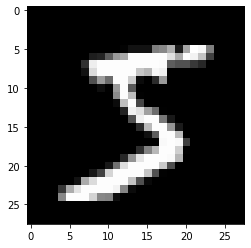

In [4]:
# what if the dataset is not available in torchvision? 
# alternative: directly download the dataset files from http://yann.lecun.com/exdb/mnist/
# extract all four gz files
# upload them directly to your Drive or to this notebook

!pip install python-mnist
from mnist import MNIST

# mount your google drive and allow access
# from google.colab import drive
# drive.mount('/content/drive')

# if you mount your drive then you need to give the path to the MNIST files when calling the MNIST() method
# otherwise if you just upload the files into this notebook they should be in the base path, so you just need to call MNIST() without giving any path
mndata = MNIST()
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

# now we need to define a custom dataset
# you can find more info at https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class MNISTCustomDataset(Dataset):
  def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
      image = self.images[idx]
      image = np.array(image, dtype=np.uint8).reshape((28, 28))
      image = Image.fromarray(image, mode='L')
      
      if self.transform:
        image = self.transform(image)

      label = int(self.labels[idx])
      return (image, label)


data_aug = transforms.Compose([transforms.ToTensor()])
training_data = MNISTCustomDataset(train_images, train_labels, transform=data_aug)
validation_data = MNISTCustomDataset(test_images, test_labels, transform=data_aug)

plt.imshow(training_data[0][0][0,:,:], cmap='gray')

In [5]:
# divide dataset into train-val-test subsets
indices = list(range(len(validation_data)))
np.random.shuffle(indices, )

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(f'Training size: {len(training_data)}\nValidation size: {len(val_idx)} \nTest size: {len(test_idx)}')

Training size: 60000
Validation size: 8000 
Test size: 2000


In [6]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


## Defining the model

Create a CNN with the following structure:

1. convolutional layer with 32 output channels and 3x3 kernel
2. ReLU activation layer
3. convolutional layer with 32 input/output channels and 3x3 kernel
4. ReLU activation layer
5. max pooling layer with a kernel size of 2
6. dropout with 0.25 probability
7. flattening layer (to convert the 3D tensors into 1D tensors to be fed to the dense layers)
8. dense/linear layer with 128 output channels
9. ReLU activation layer
10. dropout layer with 0.5 probability
11. dense/linear layer with 10 output channels (10 classes of MNIST)

You can use PyTorch's layers: https://pytorch.org/docs/stable/nn.html (Conv2d, ReLU, Linear, MaxPool2d, Dropout, Flatten)




In [7]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3

        self.layers = nn.Sequential(
            nn.Conv2d(1, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(4608, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = ConvolutionalNeuralNetwork().to(device) # put model in device (GPU or CPU)
print(model)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4608, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


Interpret the implemented architecture and try to answer the following questions:

a) What is the shape (width, height and # of channels) of the output tensor after the first convolution layer?

b) And after the first 3 layers (convolution+convolution+pooling)?

c) How many parameters (weights) does the model have? Contrary to Keras, PyTorch does not have an official method for counting the number of parameters of a model, but you can use [torchsummary](https://github.com/sksq96/torchsummary).

In [8]:
# !pip install torchsummary
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           9,248
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
           Dropout-6           [-1, 32, 12, 12]               0
           Flatten-7                 [-1, 4608]               0
            Linear-8                  [-1, 128]         589,952
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 600,810
Trainable params: 600,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## Train the model

In [9]:
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [11]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:16<00:00, 56.24it/s]


Train loss: 2.272 	 Train acc: 0.180


100%|██████████| 125/125 [00:02<00:00, 50.40it/s]


Val loss: 2.207 	 Val acc: 0.475

Epoch 2


100%|██████████| 937/937 [00:19<00:00, 49.24it/s]


Train loss: 1.896 	 Train acc: 0.510


100%|██████████| 125/125 [00:02<00:00, 58.97it/s]


Val loss: 1.194 	 Val acc: 0.779

Epoch 3


100%|██████████| 937/937 [00:17<00:00, 54.43it/s]


Train loss: 0.935 	 Train acc: 0.726


100%|██████████| 125/125 [00:02<00:00, 60.54it/s]


Val loss: 0.527 	 Val acc: 0.865

Epoch 4


100%|██████████| 937/937 [00:17<00:00, 53.73it/s]


Train loss: 0.633 	 Train acc: 0.807


100%|██████████| 125/125 [00:02<00:00, 58.83it/s]


Val loss: 0.399 	 Val acc: 0.893

Epoch 5


100%|██████████| 937/937 [00:17<00:00, 53.65it/s]


Train loss: 0.537 	 Train acc: 0.837


100%|██████████| 125/125 [00:02<00:00, 59.78it/s]


Val loss: 0.344 	 Val acc: 0.904

Epoch 6


100%|██████████| 937/937 [00:17<00:00, 53.84it/s]


Train loss: 0.481 	 Train acc: 0.856


100%|██████████| 125/125 [00:02<00:00, 58.80it/s]


Val loss: 0.311 	 Val acc: 0.911

Epoch 7


100%|██████████| 937/937 [00:17<00:00, 53.63it/s]


Train loss: 0.443 	 Train acc: 0.864


100%|██████████| 125/125 [00:02<00:00, 57.71it/s]


Val loss: 0.283 	 Val acc: 0.919

Epoch 8


100%|██████████| 937/937 [00:17<00:00, 54.16it/s]


Train loss: 0.416 	 Train acc: 0.874


100%|██████████| 125/125 [00:02<00:00, 59.02it/s]


Val loss: 0.267 	 Val acc: 0.923

Epoch 9


100%|██████████| 937/937 [00:17<00:00, 53.72it/s]


Train loss: 0.394 	 Train acc: 0.881


100%|██████████| 125/125 [00:02<00:00, 59.48it/s]


Val loss: 0.247 	 Val acc: 0.928

Epoch 10


100%|██████████| 937/937 [00:17<00:00, 53.77it/s]


Train loss: 0.374 	 Train acc: 0.889


100%|██████████| 125/125 [00:02<00:00, 59.93it/s]

Val loss: 0.234 	 Val acc: 0.933
Finished


## Analyse training evolution

In [12]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

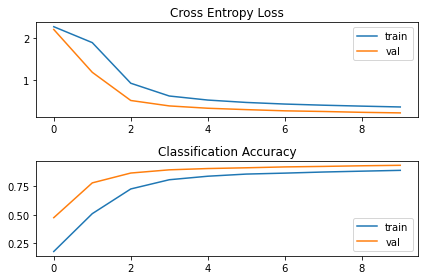

In [13]:
plotTrainingHistory(train_history, val_history)

## Test the model

In [14]:
# Evaluate the model in the test set

# load the best model (i.e. model with the lowest val loss...might not be the last model)
# we could also load the optimizer and resume training if needed

model = ConvolutionalNeuralNetwork().to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

100%|██████████| 2000/2000 [00:08<00:00, 224.37it/s]


Test Loss: 0.245 
Test Accuracy: 0.931


In [15]:
def showErrors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

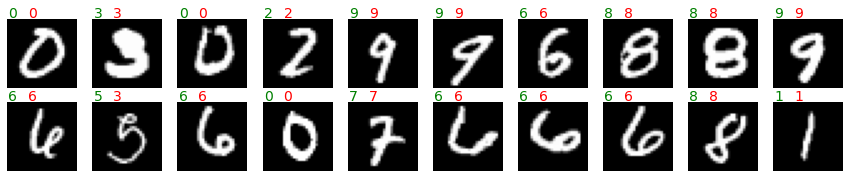

In [16]:
showErrors(model, test_dataloader)

## Additional exercises

a) What is data augmentation and why is it useful? Explore some data augmentation techniques, by using some transforms from [torchvision](https://pytorch.org/vision/stable/index.html).

b) Since training a complex model can take a very long time to train, model checkpoints can be saved and loaded later to resume the training. Explore how this can be done: https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

c) Train and test the previous model on the Fashion-MNIST and CIFAR-10 datasets. Some adaptations to the code are necessary for the latter dataset.


## Challenges (closer to the project)
Adapt the previous model, or use any of the well-known CNN architectures, to tackle one of (or both) these competitions, that consist of a binary medical image classification problem.

a) Identify metastatic cancer in small image patches (32x32) taken from larger digital pathology scans
https://www.kaggle.com/c/histopathologic-cancer-detection

b) Classify CT images into positive or negative COVID-19, depending if the image has or does not have clinical findings of COVID-19 https://covid-ct.grand-challenge.org/Data/